In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
import pickle

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from wordcloud import WordCloud
from scipy.stats import pointbiserialr

## Exploratory Data Analysis (EDA)

### 1.0 Describing Data

In [2]:
BASE_PATH = "LennarRemoteGitRepo/HousePricePrediction/"

In [3]:
train_df = pd.read_csv(f"{BASE_PATH}/data/raw/train_set")
train_df.head()

,id,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,description,lat,long,state
0,7049965813,orange county,2632,apartment,1080,2,2.0,1,1,0,0,0,0,w/d in unit,attached garage,To schedule a tour We now book our tour appoin...,33.8123,-117.8530,ca
1,7036046796,visalia-tulare,1160,apartment,768,2,1.0,1,1,1,0,0,0,laundry on site,carport,Oak View is just minutes from Highway 99 and b...,36.3008,-119.3440,ca
2,7037856890,portland,1262,apartment,1075,2,1.0,1,1,0,0,0,0,laundry on site,off-street parking,***Please Pardon Our Dust*** Do you want three...,45.5273,-122.4800,or
3,7046933042,boulder,1861,apartment,1076,2,2.0,1,1,0,0,1,0,w/d in unit,detached garage,Luna Bella Pet Friendly Community in Lafayet...,39.9744,-105.0850,co
4,7048650961,sioux falls / SE SD,626,apartment,720,1,1.0,1,1,0,0,0,0,w/d in unit,detached garage,Creekstone Falls\t Prop...,43.5179,-96.7924,sd


In [4]:
test_df = pd.read_csv(f"{BASE_PATH}/data/raw/test_set")
test_df.head()

,id,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,description,lat,long,state
0,7027550434,worcester / central MA,1750,apartment,936,2,1.0,1,0,1,0,0,0,NaN,NaN,VIEW OUR WEBSITE: https://www.winncompanies.c...,42.2526,-71.8499,ma
1,7033922487,mcallen / edinburg,850,apartment,1200,2,2.5,0,0,0,0,0,0,w/d in unit,off-street parking,"2 bedrooms, 2.5 baths, refrigerator, stove, wa...",26.2154,-98.2359,tx
2,7045296557,fort collins / north CO,1500,apartment,1029,2,1.0,1,1,0,0,0,0,w/d in unit,off-street parking,Brand New 2 bed 1 bath apartment will go FAST ...,40.3849,-105.0920,co
3,7031700539,indianapolis,899,apartment,856,2,1.0,1,1,1,0,0,0,laundry in bldg,NaN,Check out what these 2 bedrooms @ Teal Run hav...,39.7886,-85.9779,in
4,7048945590,cincinnati,595,apartment,350,0,1.0,0,0,0,0,0,0,no laundry on site,off-street parking,Completely renovated with an urban flare. 3rd ...,39.1275,-84.5350,oh


In [5]:
train_df.shape

(346479, 19)

In [6]:
test_df.shape

(38498, 19)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346479 entries, 0 to 346478
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       346479 non-null  int64  
 1   region                   346479 non-null  object 
 2   price                    346479 non-null  int64  
 3   type                     346479 non-null  object 
 4   sqfeet                   346479 non-null  int64  
 5   beds                     346479 non-null  int64  
 6   baths                    346479 non-null  float64
 7   cats_allowed             346479 non-null  int64  
 8   dogs_allowed             346479 non-null  int64  
 9   smoking_allowed          346479 non-null  int64  
 10  wheelchair_access        346479 non-null  int64  
 11  electric_vehicle_charge  346479 non-null  int64  
 12  comes_furnished          346479 non-null  int64  
 13  laundry_options          275399 non-null  object 
 14  park

In [8]:
train_df.describe()

,id,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
count,3.464790e+05,3.464790e+05,3.464790e+05,346479.000000,346479.000000,346479.000000,346479.000000,346479.000000,346479.000000,346479.000000,346479.000000,344728.000000,344728.000000
mean,7.040981e+09,1.615492e+03,1.067028e+03,1.904468,1.481110,0.726780,0.707847,0.731987,0.081939,0.012806,0.048040,37.237436,-92.706870
std,8.798642e+06,6.586159e+04,2.018564e+04,3.256987,0.618514,0.445614,0.454753,0.442925,0.274272,0.112437,0.213852,5.542563,16.522223
min,7.003808e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-43.533300,-163.894000
25%,7.035975e+09,8.060000e+02,7.500000e+02,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.465200,-100.784000
50%,7.043314e+09,1.039000e+03,9.500000e+02,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.658000,-87.772500
75%,7.048429e+09,1.395000e+03,1.150000e+03,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.141000,-81.179600
max,7.051292e+09,2.170191e+07,8.388607e+06,1100.000000,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,102.036000,172.633000


### 1.1 Checking variance of numerical columns

In [9]:
numerical_cols = ["price", "sqfeet", "beds", "baths", "lat", "long"]
for col in numerical_cols:
    print("Variance for",col,"column :", train_df[col].var())

Variance for price column : 4337748577.786544
Variance for sqfeet column : 407460235.51401496
Variance for beds column : 10.607963203245545
Variance for baths column : 0.38255925261972035
Variance for lat column : 30.720008881592843
Variance for long column : 272.98384804658565


*Key Takeaways*
- Very high variance in price and sqfeet meaning possible outliers and wide range of values.
- Low variance in bath and bedrooms ie. similar values
- Low Lat variance, and high Long variance suggesting uneven dominance of some regions

### 1.2 Checking skewness of numerical columns

In [10]:
for col in numerical_cols:
    print("Skewness for", col, "column:", train_df[col].skew())

Skewness for price column: 235.39303545130664
Skewness for sqfeet column: 388.96706906430643
Skewness for beds column: 304.2929719312646
Skewness for baths column: 10.648135085840252
Skewness for lat column: 0.249342430946829
Skewness for long column: -0.05552793176059056


*Key Takeaways*
- Price, Sqfeet, Beds, and Baths are all highly right-skewed.
- Latitude and Longitude are nearly symmetrical.

### 1.3 Checking for na values

In [11]:
# missing values
train_df.isna().sum()

id                              0
region                          0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             71080
parking_options            126565
description                     2
lat                          1751
long                         1751
state                           0
dtype: int64

*Key Takeaways:*
- laundry_options has 71,080 missing values, its Categorical, we can fill with mode (most common value)
- parking_options has 126,565 missing values, its Categorical, we can fill with mode (most common parking value: off-street parking)
- description has 2 missing values, which are insignificant, so we can drop them
- lat has 1,751	missing values, its Numeric, we can fill it with region-wise median
- long has 1,751 missing values, its Numeric, we can fill it with region-wise median

### 1.4 Checking for duplicate rows

In [12]:
train_df.duplicated().sum()

0

No duplicate rows

### 1.5 Checking value counts

In [13]:
for col in ["region", "price", "type", "sqfeet", "beds", "baths", "laundry_options", "parking_options", "state"]:
    print(train_df[col].value_counts(),"\n")

region
jacksonville      3830
columbus          3366
rochester         3306
fayetteville      3300
jackson           3299
                  ... 
southwest MS        11
southwest TX         9
st louis             7
fort smith, AR       5
kansas city          3
Name: count, Length: 404, dtype: int64 

price
750         3782
850         3602
800         3602
1200        3470
950         3267
            ... 
13995          1
26             1
3943           1
11621360       1
3516           1
Name: count, Length: 3877, dtype: int64 

type
apartment          286195
house               29978
townhouse           14329
condo                5598
duplex               4496
manufactured         3821
cottage/cabin         794
loft                  636
flat                  473
in-law                151
land                    6
assisted living         2
Name: count, dtype: int64 

sqfeet
1000    9057
900     7633
1100    6333
800     6223
700     5982
        ... 
332        1
3260       1
3410    

*Key Takeaways*

**region**
- Some regions have very few listings, these may not be reliable for model predictions due to limited data.
- Some region names have inconsistent formatting ("fort smith, AR"), this included state, which is a different feature, need standardization

**price**
- Some extreme values exist like 11621360 and 26, These are likely outliers and should be examined.

**type** (Property type)
- Apartments dominate the dataset about 286k enteries, other property types contribute much less.
- Rare categories (land, assisted living) have very few listings, so it could to a potential issue of One-hot encoding could create sparse data due to many of these categories

**sqfeet**
- It could contain extreme outlier values and its skewed, we are using log_sqfeet for normalized curve

**beds** and **baths**
- Extreme values lik 1000 beds, 75 baths are unrealistic and should be removed as outliers
- Some of the properties with zero beds, are outliers

#### Identifying outliers

In [14]:
train_df[(train_df["beds"] == 1000)]

,id,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,description,lat,long,state
25290,7036731908,youngstown,550,apartment,250,1000,25.0,0,0,0,0,0,0,NaN,street parking,2 bedroom,41.0252,-80.6687,oh


In [15]:
train_df[(train_df["beds"] == 1100)]

,id,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,description,lat,long,state
51403,7046224868,chicago,2449,apartment,1000,1100,75.0,0,0,1,0,0,0,w/d in unit,carport,Furnished or Unfurnished Units Includes Parkin...,42.0195,-87.665,il
153122,7045590325,chicago,2449,apartment,1000,1100,75.0,0,0,1,0,0,0,w/d in unit,carport,Furnished or Unfurnished Units Includes Parkin...,42.0195,-87.665,il


These above are outliers, they needs to be removed

In [16]:
train_df[(train_df['beds'] == 0)].head(2)

,id,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,description,lat,long,state
14,7036089161,college station,589,apartment,480,0,1.0,1,1,1,0,0,0,NaN,NaN,Join Us Today! @ The Gables Located less than...,30.6190,-96.3185,tx
45,7048022092,lincoln,499,apartment,495,0,1.0,1,0,0,0,0,0,laundry in bldg,off-street parking,www.LNKhousing.com | show contact info | sh...,40.7893,-96.6938,ne


Zero beds properties are outliers, needs to removed

### 1.6 Detecting outliers using Boxplots (IQR method)

In [17]:
# Function to "Plot Box Plot" and it works only for the datatype of integer and float columns.
def PBP (data):
    for col in data.select_dtypes(include=['int', 'float']).columns:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title(f'Boxplot of {col}')
        bp=data.boxplot(column=col)
        plt.show()
        plt.close(fig)

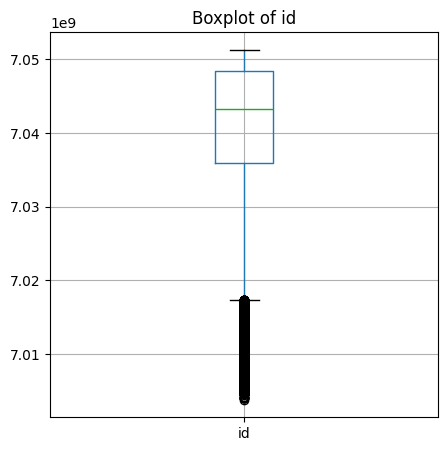

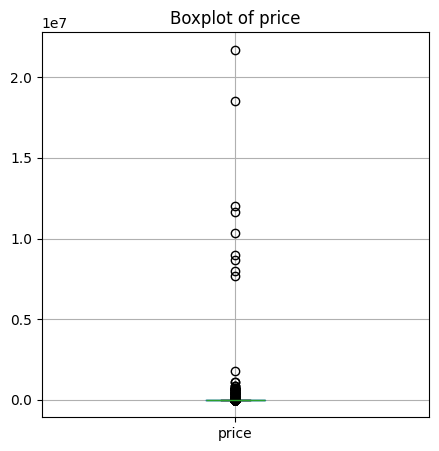

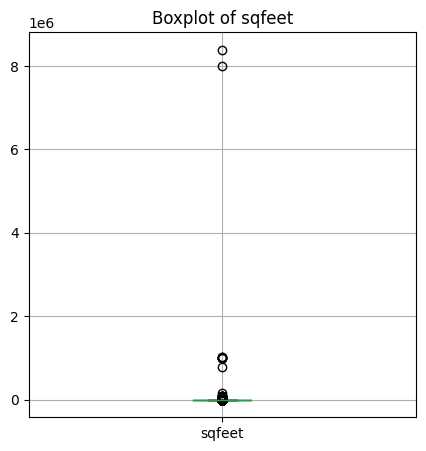

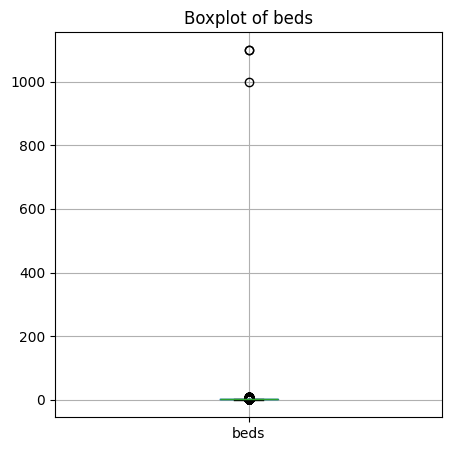

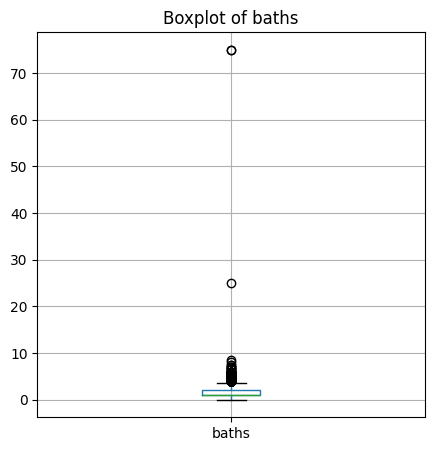

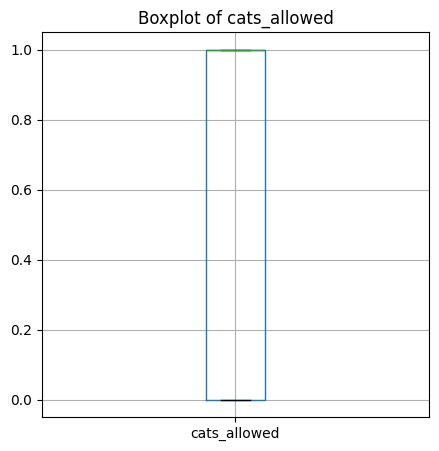

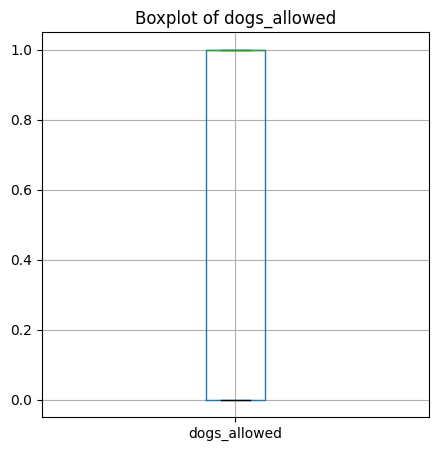

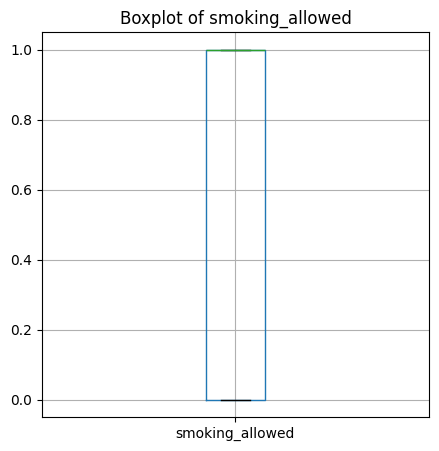

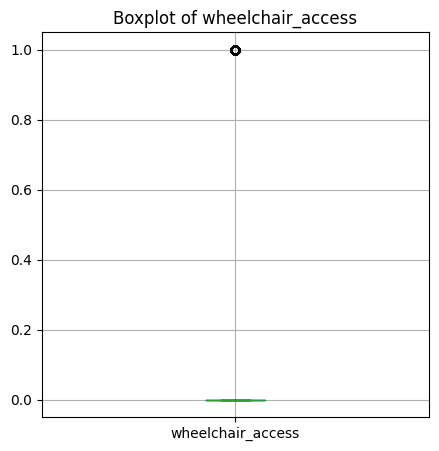

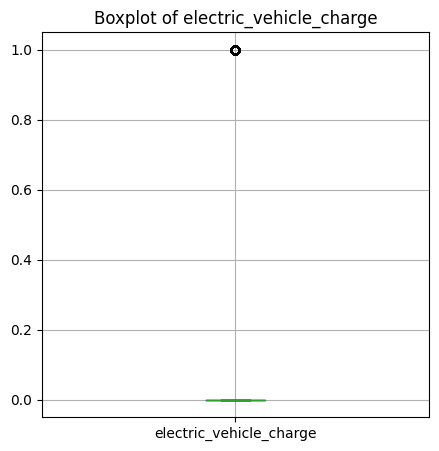

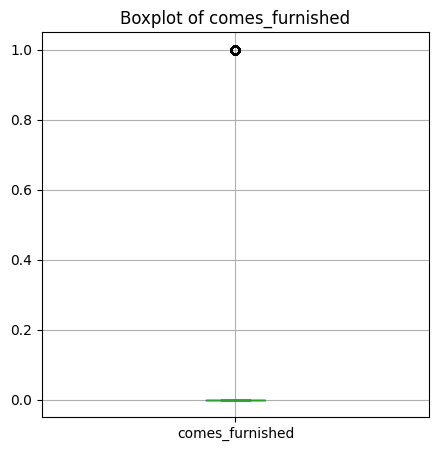

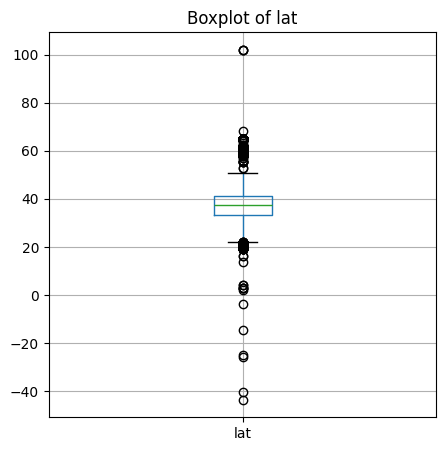

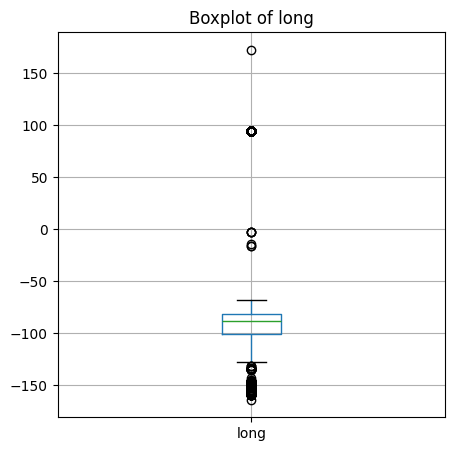

In [18]:
PBP(train_df)

**Key Takeaways for outliers**
- Price is over 500k per month for some properties and 0
- SqFeet for 2 properties is extremely large (skewed), and some of them are 0
- Properties with 0 beds, and 1000+ beds are outliers
- Properties with 25+ baths are outliers, they are 1000sqfeet, so that's not physically possible

### 1.7 Histogram/Distribution plots

In [19]:
# Function to Plot Distribution Plot
def PDP(data):
    columns = [col for col in data.columns]
    colors = sns.color_palette("dark", len(columns))
    
    for i, col in enumerate(data.select_dtypes(include=['int', 'float']).columns):
        if data[col].value_counts().count() <= 10000:
            sns.histplot(data[col], kde=True, bins=15, color=colors[i % len(colors)])
            plt.title(f'Distribution of {col}')
            plt.show()

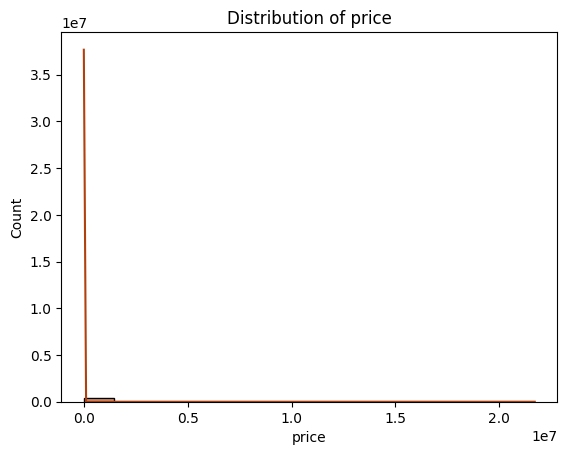

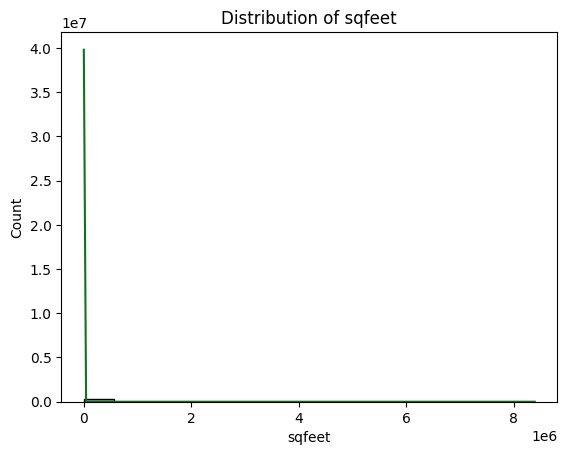

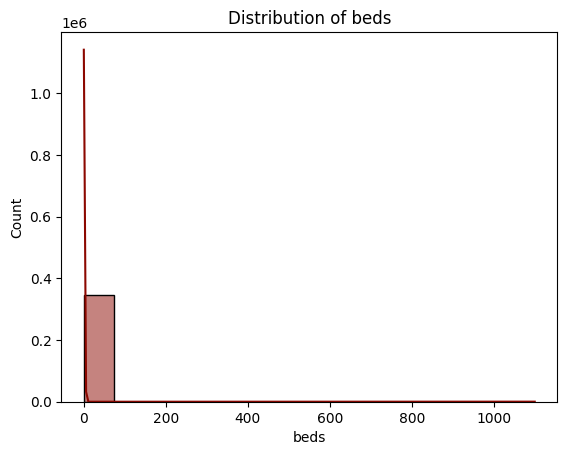

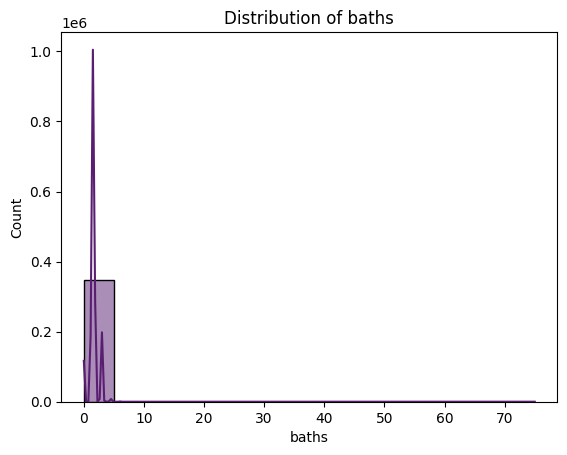

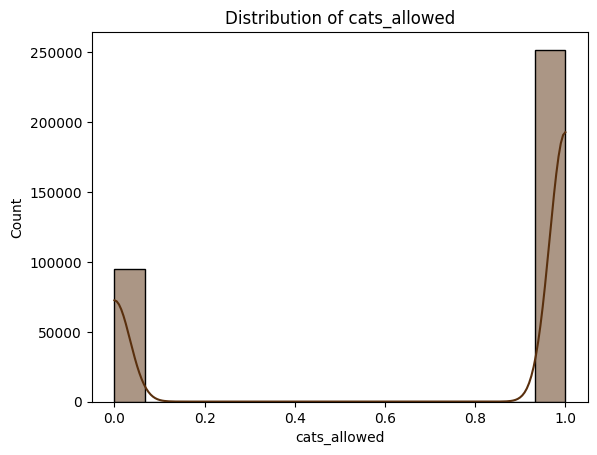

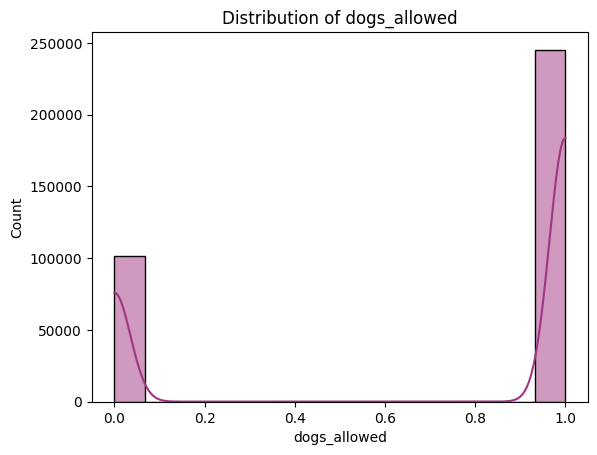

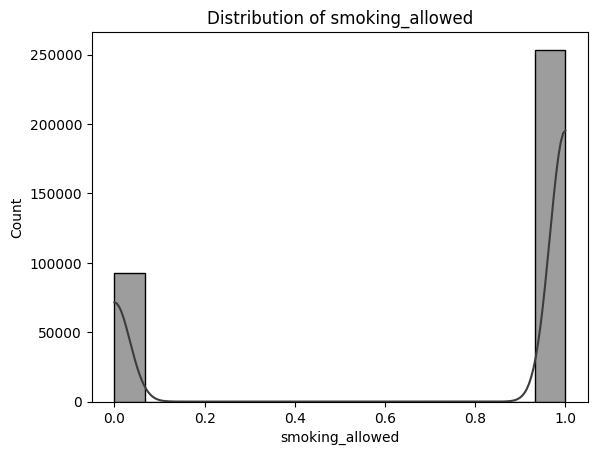

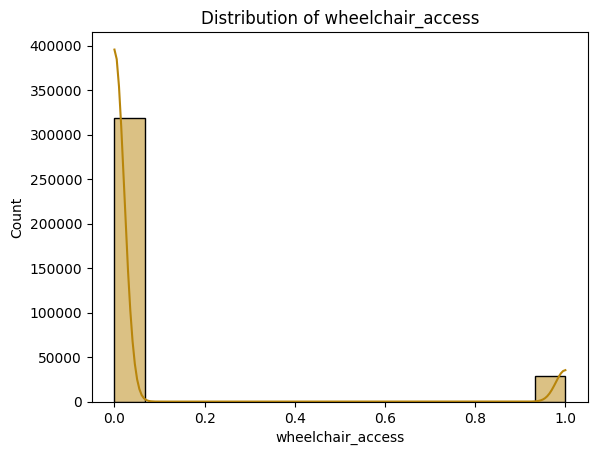

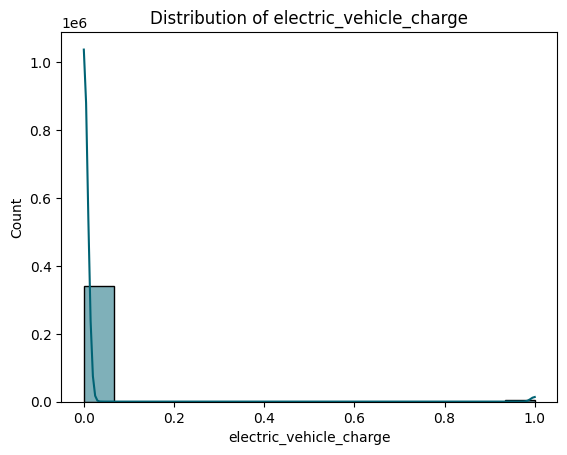

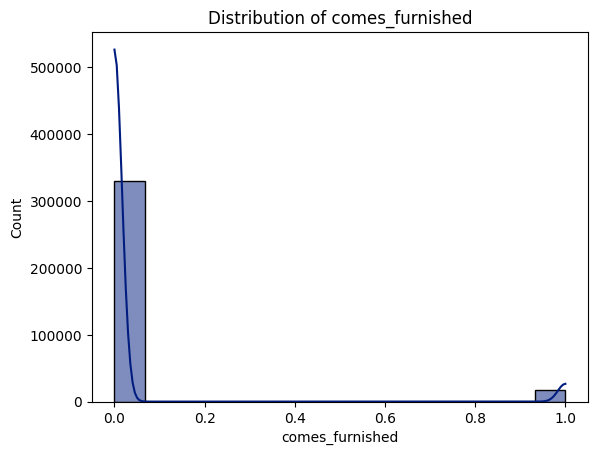

In [20]:
PDP(train_df)

### 1.8 Word Cloud: Analyzing description 

In [21]:
def preprocess_text(text):
     if isinstance(text, str):  # Check if the value is a string
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        return text
     else:
        return ""  # Return empty string for NaN or non-string values

description_cleaned = train_df['description'].dropna().apply(preprocess_text)

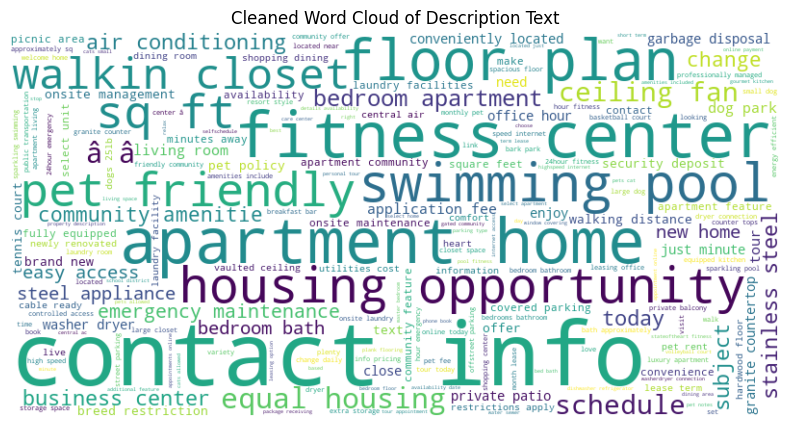

In [22]:
# Extract Key Terms using TF-IDF (removes standard English stopwords)
vectorizer = TfidfVectorizer(stop_words="english", max_features=100)
tfidf_matrix = vectorizer.fit_transform(description_cleaned)

# Get feature names (important words)
top_words = vectorizer.get_feature_names_out()

# Combine text and remove additional stopwords
text = " ".join(str(desc) for desc in description_cleaned)
wordcloud = WordCloud(
    width=800, height=400, background_color="white", max_words=200,
    stopwords=vectorizer.get_stop_words()
).generate(text)

# Display Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Cleaned Word Cloud of Description Text")
plt.show()

### 1.9 Histogram of numerical features for comparison

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'sqfeet'}>,
        <Axes: title={'center': 'beds'}>],
       [<Axes: title={'center': 'baths'}>,
        <Axes: title={'center': 'cats_allowed'}>,
        <Axes: title={'center': 'dogs_allowed'}>,
        <Axes: title={'center': 'smoking_allowed'}>],
       [<Axes: title={'center': 'wheelchair_access'}>,
        <Axes: title={'center': 'electric_vehicle_charge'}>,
        <Axes: title={'center': 'comes_furnished'}>,
        <Axes: title={'center': 'lat'}>],
       [<Axes: title={'center': 'long'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

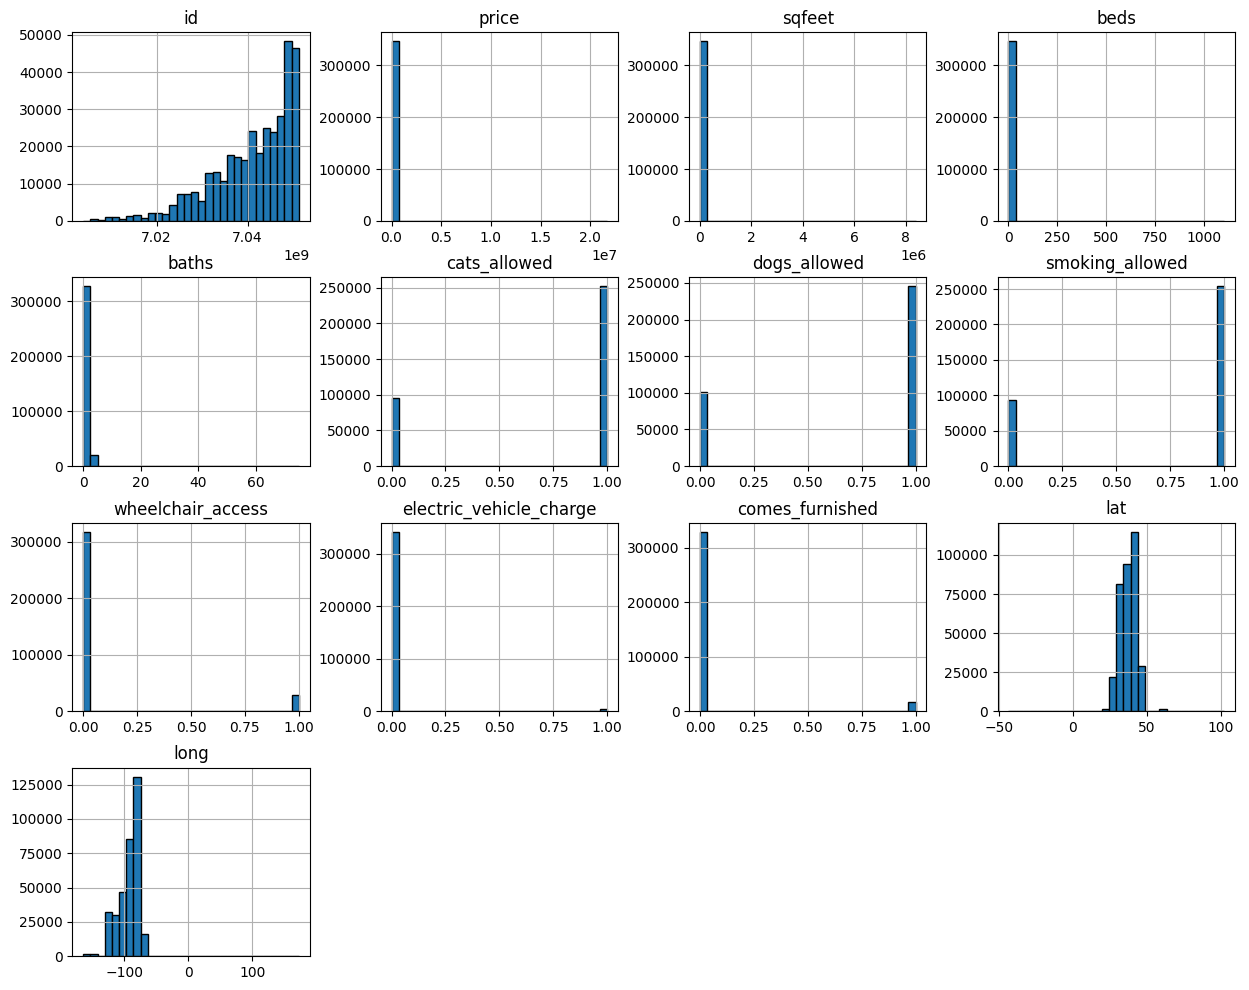

In [23]:
train_df.hist(figsize=(15, 12), bins=30, edgecolor="black")

**Key Takeaway:**
- Price and sqfeet are skewed, normal and even distribution is desired, which we achieve after removing outlier and log base it

### 1.10 Plot of showing price variation in lat, long

In [24]:
# Define price bins and corresponding colors
price_bins = [0, 1000, 2000, 3000, 4000, 5000, np.inf]
price_labels = ["<1000", "1000-2000", "2000-3000", "3000-4000", "4000-5000", "5000+"]

# Create a new column for price categories
train_df["price_category"] = pd.cut(train_df["price"], bins=price_bins, labels=price_labels, include_lowest=True)

train_df.head()

,id,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,description,lat,long,state,price_category
0,7049965813,orange county,2632,apartment,1080,2,2.0,1,1,0,0,0,0,w/d in unit,attached garage,To schedule a tour We now book our tour appoin...,33.8123,-117.8530,ca,2000-3000
1,7036046796,visalia-tulare,1160,apartment,768,2,1.0,1,1,1,0,0,0,laundry on site,carport,Oak View is just minutes from Highway 99 and b...,36.3008,-119.3440,ca,1000-2000
2,7037856890,portland,1262,apartment,1075,2,1.0,1,1,0,0,0,0,laundry on site,off-street parking,***Please Pardon Our Dust*** Do you want three...,45.5273,-122.4800,or,1000-2000
3,7046933042,boulder,1861,apartment,1076,2,2.0,1,1,0,0,1,0,w/d in unit,detached garage,Luna Bella Pet Friendly Community in Lafayet...,39.9744,-105.0850,co,1000-2000
4,7048650961,sioux falls / SE SD,626,apartment,720,1,1.0,1,1,0,0,0,0,w/d in unit,detached garage,Creekstone Falls\t Prop...,43.5179,-96.7924,sd,<1000


In [29]:
filtered_df = train_df.copy()

# Filter dataset based on latitude and longitude thresholds
filtered_df = train_df[(train_df["lat"] >= 15) & (train_df["lat"] <= 65) &
                        (train_df["long"] >= -125) & (train_df["long"] <= -50)]

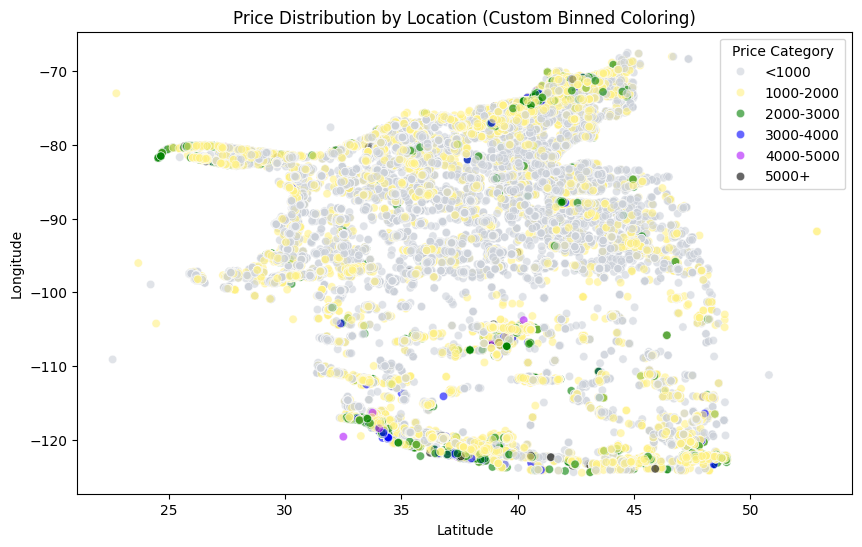

In [30]:
# Scatter plot with custom price categories
plt.figure(figsize=(10, 6))
sns.scatterplot(x="lat", y="long", data=filtered_df, hue="price_category", palette={"<1000": "#ccd1d9", "1000-2000": "#fff185", "2000-3000": "green", "3000-4000": "blue", "4000-5000": "#af14fc", "5000+": "black"}, alpha=0.6)

# Labels and title
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Price Distribution by Location (Custom Binned Coloring)")
plt.legend(title="Price Category", loc="upper right")
plt.show()

In [34]:
train_df.drop(columns=["price_category"], inplace=True)

## Saving intermediate pipeline transformed data

In [35]:
# Save CSV inside the folder
train_df.to_csv(f"{BASE_PATH}/data/interim/train_eda_processed.csv", index=False)
test_df.to_csv(f"{BASE_PATH}/data/interim/test_eda_processed.csv", index=False)